<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/Agregaciones_series_temporales_datasets_nc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.3 MB/s eta 0:00:00


In [8]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
#LEER DATASET .nc Y AREA DE ESTUDIO .nc
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis"

chirps_daily = xr.open_dataset(os.path.join(path, "NetCDF_CM/CHIRPS_Daily_CM.nc"))
area_estudio = xr.open_dataset(os.path.join(path, "NetCDF_CM/Poligonos_int.nc"))

##AGREGACION MENSUAL Y ANUAL

In [5]:
#Agregacion mensual y anual
chirps_monthly = chirps_daily.resample(time="1MS").sum()
chirps_annual= chirps_monthly.resample(time="YS").sum()

#Guardar
chirps_monthly.to_netcdf(os.path.join(path, "NetCDF_CM/CHIRPS_Monthly_CM.nc"))
chirps_annual.to_netcdf(os.path.join(path, "NetCDF_CM/CHIRPS_Annual_CM.nc"))
chirps_monthly

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 252, lat: 49, lon: 53)
Coordinates:
  * lon            (lon) float64 424B -99.45 -99.43 -99.4 ... -98.18 -98.15
  * lat            (lat) float64 392B 19.01 19.04 19.06 ... 20.16 20.19 20.21
  * time           (time) datetime64[ns] 2kB 2001-01-01 ... 2021-12-01
Data variables:
    precipitation  (time, lat, lon) float32 3MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/20)
    date_range:               [ 347155200000 1646006400000]
    description:              <p>Climate Hazards Group InfraRed Precipitation...
    keywords:                 ['chg', 'climate', 'geophysical', 'precipitatio...
    period:                   1
    period_mapping:           [ 347155200000 1646006400000]
    product_tags:             ['precipitation', 'climate', 'weather', 'geophy...
    ...                       ...
    visualization_0_bands:    precipitation
    visualization_0_max:      17.0
    visualization_0_min:      1.0
    visualization_0_name:     Precipitation
    visualization_0_palette:  001137,0aab1e,e7eb05,ff4a2d,e90000
    crs:                      EPSG:4326

##SERIES DE TIEMPO

In [24]:
# Directorio donde se guardarán las series temporales
directorio = os.path.join(path, "Series/Precipitacion")

# Inicializar un diccionario para almacenar las series temporales
series_mensuales = {}
series_anuales = {}

# Iterar sobre cada poligono en 'area_estudio' y generar una mascara
for idx, nombre_area in enumerate(area_estudio.data_vars):
    mascara = area_estudio[nombre_area]
    mascara_interpolada = mascara.interp_like(chirps_monthly, method='nearest')

    # Aplicar la mascara
    mask_prec_monthly = chirps_monthly.where(mascara_interpolada == 1)
    mask_prec_annual = chirps_annual.where(mascara_interpolada == 1)

    # Calcular la media espacial a lo largo de las dimensiones de latitud y longitud
    CHIRPS_mean_sp_monthly = mask_prec_monthly['precipitation'].mean(dim=('lon', 'lat'))
    CHIRPS_mean_sp_annual = mask_prec_annual['precipitation'].mean(dim=('lon', 'lat'))
    # Obtener los valores y las fechas como un array de NumPy
    mean_monthly = CHIRPS_mean_sp_monthly .values
    time_monthly = CHIRPS_mean_sp_monthly ['time'].values
    mean_annual = CHIRPS_mean_sp_annual.values
    time_annual = CHIRPS_mean_sp_annual['time'].values

    # Almacenar la serie temporal en el diccionario
    series_mensuales[nombre_area] = mean_monthly
    series_anuales[nombre_area] = mean_annual
# Convertir el diccionario en un DataFrame con indice de fechas
df_series_mensuales = pd.DataFrame(series_mensuales, index=pd.to_datetime(time_monthly))
df_series_mensuales.index.name = 'Fecha'
df_series_anuales = pd.DataFrame(series_anuales, index=pd.to_datetime(time_annual))
df_series_anuales.index.name = 'Fecha'

# Guardar el DataFrame en un archivo CSV
ruta_csv_m = f"{directorio}/Series_CHIRPS_monthly.csv"
ruta_csv_a = f"{directorio}/Series_CHIRPS_annual.csv"
df_series_mensuales.to_csv(ruta_csv_m)
df_series_anuales.to_csv(ruta_csv_a)
print(f"Se han generado {len(series_mensuales)} series temporales y se han guardado en {ruta_csv}.")
print(f"Se han generado {len(series_anuales)} series temporales y se han guardado en {ruta_csv}.")

Se han generado 8 series temporales y se han guardado en /gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/Series/Precipitacion/Series_CHIRPS_monthly.csv.
Se han generado 8 series temporales y se han guardado en /gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/Series/Precipitacion/Series_CHIRPS_monthly.csv.


In [25]:
df_series_mensuales

,CM,1507,1319,0901,1320,2902,1506,1508
Fecha,,,,,,,,
2001-01-01,6.116659,6.786858,6.222997,8.807042,2.554814,5.138150,8.034337,4.733104
2001-02-01,9.501001,5.442069,16.183357,10.587099,9.682186,9.560708,6.010378,9.938243
2001-03-01,9.102187,7.117355,12.713491,10.529713,8.192556,8.293275,10.814077,8.170378
2001-04-01,35.877876,44.539852,35.118855,46.199368,26.986282,38.212376,44.707569,25.811678
2001-05-01,70.899300,88.357018,48.531685,93.829163,56.176479,88.141365,86.729546,48.949257
...,...,...,...,...,...,...,...,...
2021-08-01,198.145691,192.672958,239.321594,215.695663,158.467026,179.061096,260.112366,178.843597
2021-09-01,214.795151,208.098770,272.726929,210.142776,204.657639,245.067032,170.917526,217.742279
2021-10-01,61.585842,50.208645,108.187515,67.760498,76.690094,93.838593,69.571526,39.624363


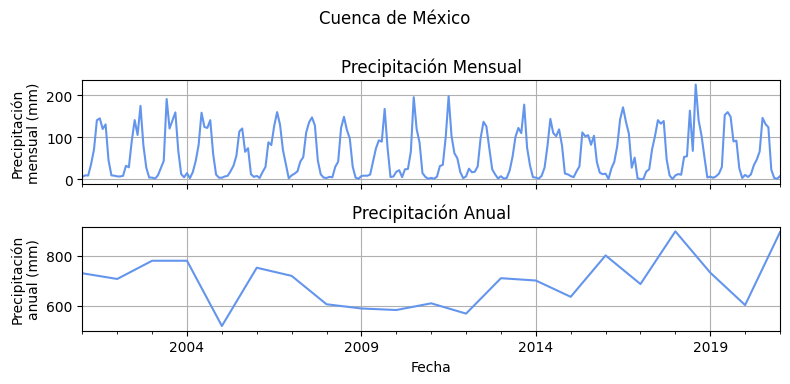

In [31]:
# GRAFICAS MENSUALES Y ANUALES DE LA CUENCA DE MEXICO
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Precipitación mensual
df_series_mensuales["CM"].plot(ax=axes[0], color="cornflowerblue", legend=False)
axes[0].set_ylabel("Precipitación\nmensual (mm)")
axes[0].set_title("Precipitación Mensual")
axes[0].grid(True)

# Precipitación anual
df_series_anuales["CM"].plot(ax=axes[1], color="cornflowerblue", legend=False)
axes[1].set_ylabel("Precipitación\nanual (mm)")
axes[1].set_title("Precipitación Anual")
axes[1].grid(True)

fig.suptitle("Cuenca de México", fontsize=12, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()